<h1>Email recipient recommendation

<p>Team: Daft.py
<p>ZHENG Chengyi, TIAN Yu, ZHOU Peikun

<h3>Import the package required

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy
import pylab
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
from pylab import rcParams
import pickle
from sklearn.metrics.pairwise import cosine_similarity as c_s
import operator
import math
import os


rcParams['figure.figsize'] = 20, 5

<h2>Data Cleansing

Functions

In [3]:
def check_info_set(info_filename,set_filename):
    training_info = pd.read_csv(info_filename, sep=',', header=0)
    training = pd.read_csv(set_filename, sep=',', header=0)

    mailIds2 = []
    for mails in training['mids'].tolist():
        mails = mails.split(' ')
        mailIds2.append(mails)
    print "%d senders,correct!"%len(mailIds2) if len(mailIds2)==125 else "Sender(s) missing"

    mailIds2 = [int(mail) for sublist in mailIds2 for mail in sublist]

    print "There are %d mails in training_set"%len(mailIds2)

    print "There are %d mails in training_info"%len(training_info['mid'].tolist())

    print "Checked, they are in Bijection" if set(mailIds2)==set(training_info['mid'].tolist()) else "Not the same"

In [38]:
def count_by_date(training_info):
    training_info.date = training_info.date.astype("datetime64[ns]")
    training_info['date'].groupby([training_info.date.dt.year,training_info.date.dt.month]).count().plot.bar()
    plt.show()

check Dateset

In [5]:
info_filename = '../data/training_info.csv'
set_filename = '../data/training_set.csv'
check_info_set(info_filename, set_filename)

125 senders,correct!
There are 43613 mails in training_set
There are 43613 mails in training_info
Checked, they are in Bijection


Merge train_info and train_set

In [6]:
training = pd.read_csv(set_filename, sep=',', header=0)
list_sender = []
list_mid = []

for index,serie in training.iterrows():
    row = serie.tolist()
    sender = row[0]
    ids = row[1].split(" ")
    ids = [int(x) for x in ids]
    for mid in ids:
        list_sender.append(sender)
        list_mid.append(mid)

merged_train = pd.DataFrame({"sender":list_sender, "mid":list_mid})

training_info = pd.read_csv(info_filename, sep=',', header=0)

merged_train = pd.merge(merged_train,training_info)
merged_train = merged_train.sort_values(by='date',ascending=True)

merged_train.mid = merged_train.mid.astype(int)

merged_train.head()

,mid,sender,date,body,recipients
43279,47361,enron_update@concureworkplace.com,0001-08-26 22:16:36,The following reports have been waiting for yo...,kimberly.watson@enron.com
43280,47362,enron_update@concureworkplace.com,0001-08-27 22:21:02,The following reports have been waiting for yo...,kimberly.watson@enron.com
43281,47363,enron_update@concureworkplace.com,0001-08-28 22:25:35,The following reports have been waiting for yo...,kimberly.watson@enron.com
43282,45909,enron_update@concureworkplace.com,0001-09-13 22:24:08,Employee Name: Kimberly WatsonReport Name: E...,kimberly.watson@enron.com
43283,82030,enron_update@concureworkplace.com,0001-09-17 09:24:00,The following expense report is ready for appr...,barry.tycholiz@enron.com


Data distribution

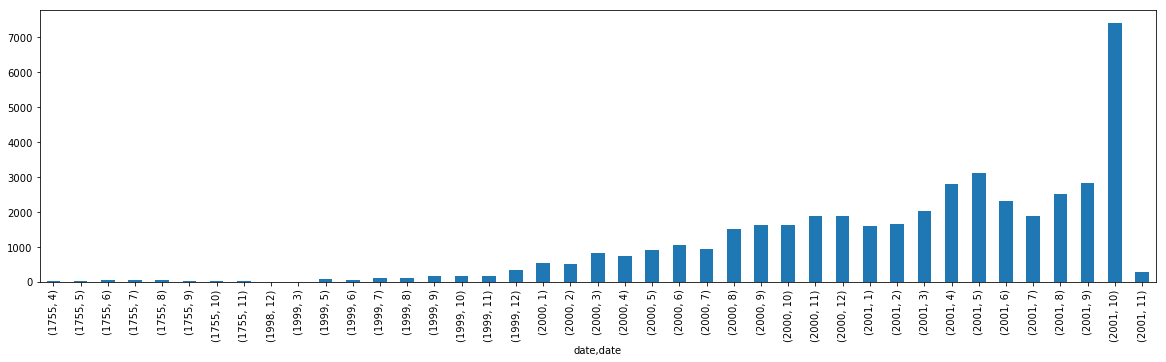

In [9]:
# merged_filename = '../data/merged_data/merged_train.csv'
count_by_date(merged_train)

Remove mails with wrong date

In [10]:
day = numpy.datetime64('1998-01-01').astype("datetime64[ns]")
weird_date = merged_train[merged_train.date.astype("datetime64[ns]") < day]['date'].tolist()
weird_date = [numpy.datetime64(x).astype("datetime64[Y]") for x in weird_date]
print Counter(weird_date)

Counter({numpy.datetime64('1755'): 202})


In [11]:
merged_train = merged_train[merged_train.date.astype("datetime64[ns]") > day]
merged_train.head()

,mid,sender,date,body,recipients
21189,9716,michelle.cash@enron.com,1998-12-21 05:29:00,"Brent,Attached is a form indemnification agree...",brent.hendry@enron.com mark.e.taylor@enron.com
38268,7830,christian.yoder@enron.com,1999-03-02 07:30:00,"As you are already aware, the West desk is ma...",elizabeth.sager@enron.com mark.e.taylor@enron....
8695,90523,larry.f.campbell@enron.com,1999-05-03 09:44:00,Go for it!George Robinson04/27/99 04:14 PMTo: ...,butch.russell@enron.com george.robinson@enron.com
8696,89475,larry.f.campbell@enron.com,1999-05-05 05:27:00,Just a short message to apprise everyone of th...,william.kendrick@enron.com rick.cates@enron.co...
8697,89618,larry.f.campbell@enron.com,1999-05-05 05:27:00,Just a short message to apprise everyone of th...,william.kendrick@enron.com rick.cates@enron.co...


Remove the recipients without '@'

In [12]:
for index,serie in merged_train.iterrows():
    row = serie.tolist()
    recipients = row[4].split(" ")
    recipients = [x for x in recipients if '@' in x]
    recipients = " ".join(recipients)
    merged_train.set_value(index,'recipients',recipients)

Distribution of recipient numbers

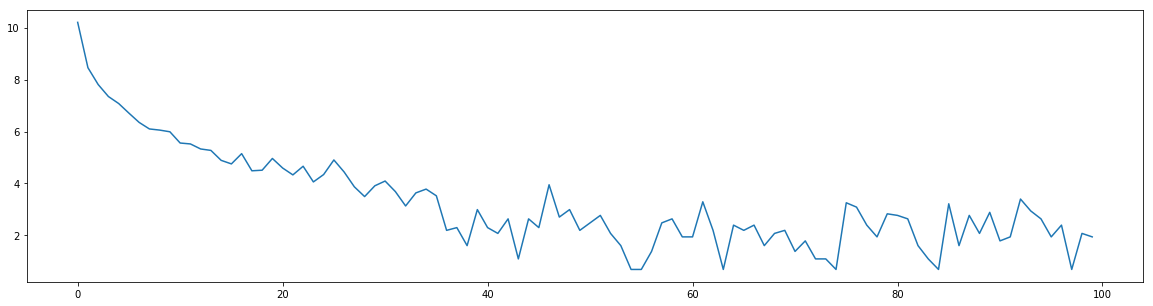

In [55]:
num_rec = []
for recs in merged_train.recipients:
    num_rec.append(len(recs.split(' ')))
    
labels, values = zip(*Counter(num_rec).items())
# values = [math.log(x) for x in values]
indexes = numpy.arange(len(labels))
plt.plot(indexes, [math.log(x) for x in values])
plt.show()

Remove the mails noisy -- remove those mails who has more than 100 recipients

In [15]:
to_retain = []
for index,serie in merged_train.iterrows():
    row = serie.tolist()
    mid = row[0]
    recipients = row[4]
    if 0< len(recipients.split(" ")) <=100:
        to_retain.append(mid)
        
merged_train = merged_train[merged_train.mid.isin(to_retain)]

Recheck the number of recipients

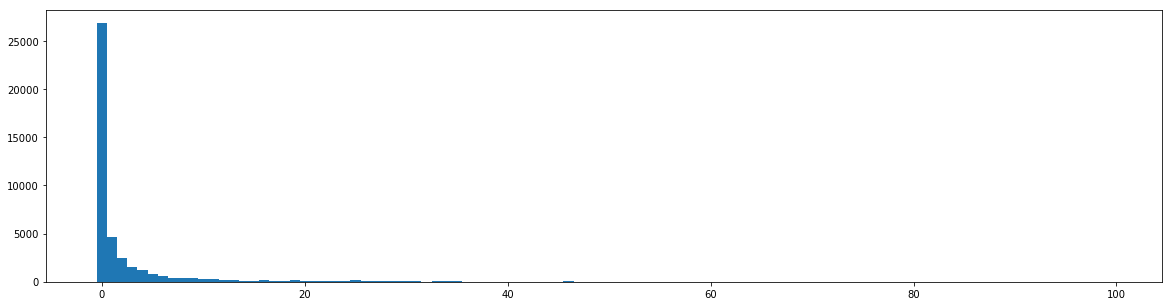

In [16]:
num_rec = []
for recs in merged_train.recipients:
    num_rec.append(len(recs.split(' ')))
labels, values = zip(*Counter(num_rec).items())
indexes = numpy.arange(len(labels))
plt.bar(indexes, values,1)
plt.show()

In [19]:
merged_train.to_csv('../data/merged_data/merged_train.csv',index=False)

Merge test data by the same way as train

In [17]:
info_filename = '../data/test_info.csv'
set_filename = '../data/test_set.csv'
check_info_set(info_filename, set_filename)

125 senders,correct!
There are 2362 mails in training_set
There are 2362 mails in training_info
Checked, they are in Bijection


In [18]:
test_set_filename = '../data/test_set.csv'
test = pd.read_csv(test_set_filename, sep=',', header=0)

list_sender = []
list_mid = []

for index,serie in test.iterrows():
    row = serie.tolist()
    sender = row[0]
    ids = row[1].split(" ")
    ids = [int(x) for x in ids]
    for mid in ids:
        list_sender.append(sender)
        list_mid.append(int(mid))

merged_test = pd.DataFrame({"sender":list_sender, "mid":list_mid})

test_info_filename = '../data/test_info.csv'
test_info = pd.read_csv(test_info_filename, sep=',', header=0)

merged_test = pd.merge(merged_test,test_info)
merged_test = merged_test.sort_values(by='date',ascending=True)
merged_train.mid = merged_train.mid.astype(int)
merged_test.to_csv('../data/merged_data/merged_test.csv',index=False)

<h2>Text Preprocessing

Functions

In [21]:
def CleanStw(text):
    from nltk.corpus import stopwords
    import re
    StpWds = stopwords.words('english')
    text = ' '.join([word for word in re.sub('\W|_',' ',text).lower().split() if word not in StpWds])
    return text
def Stemming(text):
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    text = ' '.join([stemmer.stem(word) for word in text.split(" ")])
    return text
def textClean(text):
    import re
    text = Stemming(CleanStw(re.sub("\d","",text)))
    return text if not text=='' else '0'

Clean all the mail text before the computation to speed it up

In [22]:
merged_train_filename = '../data/merged_data/merged_train.csv'
merged_train = pd.read_csv(merged_train_filename, sep=',', header = 0)

for index,seris in merged_train.iterrows():
    row = seris.tolist()
    body = row[3]
    body = textClean(body)
    merged_train.set_value(index,'body',body)
    
merged_train['body'].fillna('0', inplace=True)

In [23]:
merged_train.head()

,mid,sender,date,body,recipients
0,9716,michelle.cash@enron.com,1998-12-21 05:29:00,brent attach form indemnif agreement approv us...,brent.hendry@enron.com mark.e.taylor@enron.com
1,7830,christian.yoder@enron.com,1999-03-02 07:30:00,alreadi awar west desk make effort introduc fi...,elizabeth.sager@enron.com mark.e.taylor@enron....
2,90523,larry.f.campbell@enron.com,1999-05-03 09:44:00,go georg robinson pmto larri campbel et enron ...,butch.russell@enron.com george.robinson@enron.com
3,89475,larry.f.campbell@enron.com,1999-05-05 05:27:00,short messag appris everyon clean result perfo...,william.kendrick@enron.com rick.cates@enron.co...
4,89618,larry.f.campbell@enron.com,1999-05-05 05:27:00,short messag appris everyon clean result perfo...,william.kendrick@enron.com rick.cates@enron.co...


In [24]:
merged_test_filename = '../data/merged_data/merged_test.csv'
merged_test = pd.read_csv(merged_test_filename, sep=',', header = 0)

for index,seris in merged_test.iterrows():
    row = seris.tolist()
    body = row[3]
    body = textClean(body)
    merged_test.set_value(index,'body',body)
    
merged_test['body'].fillna("0", inplace=True)



In [25]:
merged_test.head()

,mid,sender,date,body
0,284098,jonathan.mckay@enron.com,2001-11-02 05:25:29,everyon mother child father hope everyth went ...
1,272008,dutch.quigley@enron.com,2001-11-02 05:34:55,origin messag wesner soong sarah sent thursday...
2,49273,james.d.steffes@enron.com,2001-11-02 05:57:55,janin ok cover whole countri forgotten discuss...
3,71901,kim.ward@enron.com,2001-11-02 06:10:47,0
4,82354,barry.tycholiz@enron.com,2001-11-02 06:17:44,wow posit beauti wife sign haul three rug rat ...


In [26]:
merged_train.to_csv('../data/merged_data/merged_train_textClean.csv',index=False)
merged_test.to_csv('../data/merged_data/merged_test_textClean.csv',index=False)

<h2>Ranking

<p> Fit a TfidfVectorizer and save it

In [28]:
merged_train = pd.read_csv('../data/merged_data/merged_train_textClean.csv', sep=',', header=0)
Tfidf = TfidfVectorizer()
Tfidf.fit(merged_train.body.tolist())
pickle.dump(Tfidf, open("../data/merged_data/Tfidfvectorizer.pickle", "wb"))

Functions

In [35]:
def get_emails_ids_per_sender(training):
    sender_list = list(set(training.sender.tolist()))
    emails_ids_per_sender = {}    
    for s in sender_list:
        emails_ids_per_sender[s] = [int(x) for x in training[training.sender==s]['mid'].tolist()]
    return emails_ids_per_sender

In [29]:
def rcy(t_new,t_m):
    t_new = np.datetime64(t_new).astype('datetime64[D]')
    t_m = np.datetime64(t_m).astype('datetime64[D]')
    d = (t_new - t_m).astype(float) + 1.0
    return round(d**(-1.5),10) if 0<d<365 else 0

In [30]:
def rk(score_dic):
    return {key: rank for rank, key in enumerate(sorted(score_dic, key=score_dic.get, reverse=True), 1)}

def Rank_all(rank_r, rank_c, alpha=0.6):
    rank = {}
    for k in rank_r.iterkeys():
        r_r = alpha/rank_r[k] if rank_r.get(k,0)!=0 else 0
        r_c = (1-alpha)/rank_c[k] if rank_c.get(k,0)!=0 else 0
        rank[k] = r_r + r_c
    sorted_rank = [x[0] for x in sorted(rank.items(), key=operator.itemgetter(1),reverse=True)]        
    return sorted_rank

In [31]:
def Rcy_rank(new_mail,address_books,contact_books,df):
    mid = new_mail[0]
    sender = new_mail[1]
    t_new = new_mail[2]
    b_new = new_mail[3]
    
    ran = {}

    for rec in address_books[sender]:
        score = 0
        cache = df[df.mid.isin(contact_books[sender][rec])]['date'].tolist()
        for d in cache:
            r = 6*rcy(t_new,d)
            score += r
        if contact_books.has_key(rec) and contact_books[rec].has_key(sender):
            cache = df[df.mid.isin(contact_books[rec][sender])]['date'].tolist()
            for d in cache:
                r = rcy(t_new,d)
                score += r
            
        ran[rec] = score
    return rk(ran)

In [32]:
def Cnt_rank(new_mail,address_books,contact_books,df,Tfidf=TfidfVectorizer()):
    mid = new_mail[0]
    sender = new_mail[1]
    t_new = new_mail[2]
    b_new = Tfidf.transform([new_mail[3]]).toarray()
    ran = {}
    
    for rec in address_books[sender]:
        score = 0
        cache = df[df.mid.isin(contact_books[sender][rec])]['body'].tolist()
        a_m = Tfidf.transform(cache).toarray()
        centroid_out = np.mean(a_m, axis=0).reshape(1,-1)
        score = 6*c_s(b_new,centroid_out)
        if contact_books.has_key(rec) and contact_books[rec].has_key(sender):
            cache = df[df.mid.isin(contact_books[rec][sender])]['body'].tolist()
            b_m = Tfidf.transform(cache).toarray()
            centroid_in = np.mean(b_m, axis=0).reshape(1,-1)
            score += c_s(b_new,centroid_in)

        ran[rec] = score
    return rk(ran)

Some data structures

In [36]:
tfidf = pickle.load(open("../data/merged_data/Tfidfvectorizer.pickle", "rb"))

test = pd.read_csv('../data/merged_data/merged_test_textClean.csv', sep=',', header=0)
train = pd.read_csv('../data/merged_data/merged_train_textClean.csv', sep=',', header=0)

# test = pd.read_csv('../data/merged_data/eva_test.csv', sep=',', header=0)
# train = pd.read_csv('../data/merged_data/eva_train.csv', sep=',', header=0)

emails_ids_per_sender = get_emails_ids_per_sender(train)
all_senders = emails_ids_per_sender.keys()

address_books = {}
for sender in all_senders:
    book = train[train.sender==sender]['recipients'].tolist()
    book = [x for subitem in book for x in subitem.split(" ")]
    book = list(set(book))
    address_books[sender] = book

contact_books = {}
for sender in all_senders:
    mails = train[train.sender==sender]
    book = {}
    for rec in address_books[sender]:
        rec_mail =mails[mails.recipients.str.contains(rec)]['mid'].tolist()
        book[rec] = rec_mail
    contact_books[sender] = book

make predictions and output to a txt file

In [ ]:
with open("../results/rcy_cnt_prediction.txt", 'wb') as my_file:
    my_file.write('mid,recipients' + '\n')
    i = 0
    for index,serie in test.iterrows():
        row = serie.tolist()
        mid = str(row[0])
        d1 = Rcy_rank(row,address_books,contact_books,train)
        d2 = Cnt_rank(row,address_books,contact_books,train,Tfidf=tfidf)
        rn = Rank_all(d1,d2)
        my_file.write(mid + ',' + ' '.join(rn[:10]) + '\n')

        i += 1
        if i%50=0
            print i
        
    my_file.close()